# MNIST 

In this example, we consider the classic machine learning dataset MNIST and the task of classifying handwritten digits. By modern computer vision standards this dataset is considered small, yet it is sufficiently large that many standard classifiers (e.g. those in the Python package `sklearn`) require significant time to train a model. Nonetheless, [Epsilon](http://epopt.io/) is able to fit a model that achieves near state-of-the-art accuracy in a few minutes. 

<img src="mnist.png" />

The standard task is to train a multiclass classifier that can correctly identify digits from their pixel intensity values. For the purposes of this example, we simplify this task slightly and instead consider the binary classification task of even vs. odd. To build our classifier we have a training set of 60K images of dimension 28x28 and a test set of 10K images.

In [2]:
%matplotlib inline
import io
import urllib
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as LA
import epopt as ep

mnist = np.load(io.BytesIO(urllib.urlopen("http://epopt.s3.amazonaws.com/mnist.npz").read()))

## Hinge loss and support vector machines

Mathematically we will set up our problem with a set of training examples $(X, y)$ where $y \in \{-1,1\}^m$ is the set of binary labels and $X$ is a matrix containing $m$ training examples with $n$ input features (the features for each, $x_i \in \mathbb{R}^n$, are arranged as the rows of matrix $X \in \mathbb{R}^{m \times n}$). Given this training set, we will fit the parameters of our model by minimizing a loss function over the training data
$$
\DeclareMathOperator{\minimize}{minimize} \minimize \;\; \ell(\theta; X, y), 
$$
where $\theta \in \mathbb{R}^n$ denotes model parameters. A natural loss for classification is the 0-1 loss: we incur a penalty of 1 for each incorrect classification and 0 otherwise. This loss function is nonconvex and so instead we minimize a convex surrogate, the *hinge loss*
$$
\ell(\theta; X, y) = \sum_{i=1}^m \max \{0, 1 - y_i(\theta^Tx_i) \}.
$$
The hinge loss is in fact the tightest possible convex surrogate for the 0-1 loss as can be seen from the following picture:


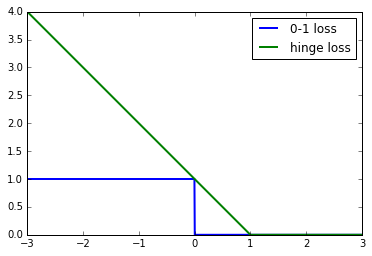

In [3]:
# z = y*p is the product of the label and the prediction, i.e. z>0 is a correct prediction
z = np.linspace(-3, 3, 1000)
plt.plot(z, z < 0, linewidth=2)
plt.plot(z, np.maximum(0, 1 - z), linewidth=2)
_ = plt.legend(("0-1 loss", "hinge loss"))

In order to minimize this function using CVXPY and Epsilon, we must write down its definition which is a single line of Python. For convenience, Epsilon provides the `hinge_loss()` function as well as several others, see [`functions.py`](https://github.com/mwytock/epsilon/blob/master/python/epopt/functions.py) for more details.

In [2]:
def hinge_loss(theta, X, y):
    return cp.sum_entries(cp.max_elemwise(1 - sp.diags([y],[0])*X*theta, 0))

We will also add a bit of $\ell_2$-regularization on the parameter vector $\theta$, the final optimization problem is
$$
\minimize \;\; \ell(\theta; X, y) + \lambda \|\theta\|_2^2
$$
where the parameter $\lambda > 0$ controls the amount of regularization (and therefore, the bias-variance tradeoff between over/underfitting the data). Formulating this problem in CVXPY and solving it with Epsilon is done as follows: 

In [4]:
# Problem data
X = mnist["X"] / 255.                  # raw pixel data scaled to [0, 1]
y = (mnist["Y"].ravel() % 2 == 0)*2-1  # labels converted to {-1,1}
Xtest = mnist["Xtest"] / 255.
ytest = (mnist["Ytest"].ravel() % 2 == 0)*2-1

# Parameters
m, n = X.shape
theta = cp.Variable(n)
lam = 1

# Form problem with CVXPY and solve with Epsilon
f = ep.hinge_loss(theta, X, y) + lam*cp.sum_squares(theta)
prob = cp.Problem(cp.Minimize(f))
ep.solve(prob, verbose=True)

# Get solution and evaluate 0-1 error
def error(x, y):    
    return 1 - np.sum(x == y) / float(len(x))

theta0 = np.ravel(theta.value)
print "Train error:", error((X.dot(theta0)>0)*2-1, y)
print "Test error:", error((Xtest.dot(theta0)>0)*2-1, ytest)

Epsilon 0.2.4
Compiled prox-affine form:
objective:
  add(
    sum_hinge(var(x)),
    sum_square(var(y)))

constraints:
  zero(add(add(dense(a)*1.00, scalar(-1.00)*dense(B)*var(y)), scalar(-1.00)*var(x)))
Epsilon compile time: 3.1065 seconds

iter=0 residuals primal=1.52e+02 [2.47e+00] dual=1.92e+02 [1.55e+00]
iter=70 residuals primal=8.04e-01 [6.23e+00] dual=1.13e+00 [1.28e+00]
Epsilon solve time: 24.0632 seconds
Train error: 0.0961833333333
Test error: 0.0979


Thus, a simple linear classifier on pixel intensities achieves a 9.8% error rate on this task. This forms a reasonable baseline, but raw pixel values are in fact poor predictors and we can do much better by considering a nonlinear decision functions which we explore next. 

First, its worth noting that the hinge loss also naturally arises in the derivation of  [support vector machines](https://en.wikipedia.org/wiki/Support_vector_machine). In addition, SVMs allow efficient learning of non-linear classification boundaries via their dual formulation and the "kernel trick". In fact, SVMs with Gaussian kernel  
$$ k(x, x') = \exp\left( \frac{-\|x - x'\|^2}{2\sigma^2}  \right) $$
are known to perform very well on MNIST.

Unfortunately as the size of the training set is 60K, explicitly instantiating the kernel matrix (60K x 60K) is prohibitively expensive for this problem. Instead, we will use a recent method based on random Fourier features which approximates the kernel distance function.

## Non-linear classifier using random Fourier features

Rather remarkably, it turns out that transforming the input data with random features
$$
z(x) = \cos(Wx + b)
$$
with $W \in \mathbb{R}^{d \times n}$ and $b \in \mathbb{R}^d$; The elements of $W$ are sampled from a zero-mean Normal distribution $\mathcal{N}(0, \sigma^2)$ and the elements of $b$ are chosen uniformly at random from $[0, 2\pi]$. When the input features are transformed in this fashion, their inner product approximates the Gaussian kernel
$$
z(x)^Tz(x') \approx k(x, x'),
$$
for the complete mathematical details see [Rahimi and Recht (2007)](http://www.eecs.berkeley.edu/~brecht/papers/07.rah.rec.nips.pdf).

Our implementation of this idea (e.g. the use of PCA, median trick) is inspired by a [recent paper](http://arxiv.org/abs/1310.1949) ([code](https://github.com/fest/secondorderdemos)) which reports near state-of-the-art performance on the MNIST digit classification class. 

These transformations are straightforward to implement in a few lines of Python:

In [37]:
def median_dist(X):
    """Compute the approximate median distance by sampling pairs."""
    k = 1<<20  # 1M random points
    i = np.random.randint(0, Xp.shape[0], k)
    j = np.random.randint(0, Xp.shape[0], k)
    return np.sqrt(np.median(np.sum((Xp[i,:] - Xp[j,:])**2, axis=1)))
    
def pca(X, dim):
    """Perform centered PCA."""
    X = X - X.mean(axis=0)
    return LA.eigh(X.T.dot(X))[1][:,-dim:]

# PCA and median trick
np.random.seed(0)
V = pca(mnist["X"], 50)
X = mnist["X"].dot(V)
sigma = median_dist(X)

# Random features
n = 4000
W = np.random.randn(Xp.shape[1], n) / sigma
b = np.random.uniform(0, 2*np.pi, n)
X = np.cos(X.dot(W) + b)
Xtest = np.cos(mnist["Xtest"].dot(V).dot(W) + b)

Given our transformed dataset we now have a larger feature matrix ($X \in \mathbb{R}^{60000 \times 4000}$) but we fit the model using the same method consisting of hinge loss and $\ell_2$-regularization. 

In [41]:
# Parameters
m, n = X.shape
theta = cp.Variable(n)
lam = 10

# Form problem with CVXPY and solve with Epsilon
f = ep.hinge_loss(theta, X, y) + lam*cp.sum_squares(theta)
prob = cp.Problem(cp.Minimize(f))
ep.solve(prob, verbose=True)

# Get solution
theta0 = np.ravel(theta.value)
print "Train error:", error((X.dot(theta0)>0)*2-1, y)
print "Test error:", error((Xtest.dot(theta0)>0)*2-1, ytest)

Epsilon 0.2.4
Compiled prox-affine form:
objective:
  add(
    sum_hinge(var(x)),
    sum_square(var(y)))

constraints:
  zero(add(add(dense(a)*1.00, scalar(-1.00)*dense(B)*var(y)), scalar(-1.00)*var(x)))
Epsilon compile time: 9.6309 seconds

iter=0 residuals primal=7.23e+01 [2.47e+00] dual=2.33e+02 [1.07e+00]
iter=80 residuals primal=4.63e-01 [6.14e+00] dual=1.54e+00 [1.59e+00]
Epsilon solve time: 136.8507 seconds
Train error: 0.00685
Test error: 0.0129


Our classifier now achieves an error rate of 1.3% improving significantly over the baseline. The current version of Epsilon (0.2.4) is able to fit the parameters of this model in <2.5 minutes which is itself significantly faster than several of the dedicated classifier implementations available in standard packages (e.g. Python's `sklearn`). 

## Conclusions

This example provides a quick introduction to achieving very good results on the classical machine learning task MNIST. [Epsilon](http://epopt.io/) along with the environment provided by [CVXPY](http://cvxpy.org) and [NumPy](http://numpy.org) make it very fast to iterate on this classifier, e.g. we could expeirment with different random features, add $\ell_1$-regularization instead of or in addition to the $\ell_2$-regularization, perform more careful cross-validation, etc...

In addition to these refinements on this application, there are several items on the Epsilon roadmap which are relevant here
- proximal operators for multiclass classification (e.g. multiclass hinge loss, softmax, etc.) - would allow us to efficiently solve the standard MNIST problem directly 
- warm start - would allow for more efficient cross-validation by caching work across nearly identical problem instances 
- multicore support - splitting the data matrix by row would likely improve convergence speed significantly
- GPU support - in this problem the main bottleneck is dense linear algebra---this could be much faster with a GPU implementation